# Analysis of Yelp Business Intelligence Data
We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-yelpdata-yh/yelp_academic_dataset_business.json

# Installation and Initial Setup

In [1]:
%info

In [70]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")
sc.install_pypi_package("numpy==1.18.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package already installed for current Spark context!
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/context.py", line 1110, in install_pypi_package
    raise ValueError("Package already installed for current Spark context!")
ValueError: Package already installed for current Spark context!



In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.18.3
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.0
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
df = spark.read.json('s3://sta9760-yelpdata-yh/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

In [7]:
df.createOrReplaceTempView("business")
bus = spark.sql('select business_id,name,city,state,stars,categories from business limit 5')
bus.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|2utGLjz9HlhK6QqPO...|         Tim Hortons|    Vaughan|   ON|  2.0|Breakfast & Brunc...|
|yyvWWWGuoMWyINaOf...|Pas D'cochon Dans...|   Montréal|   QC|  4.0|   Food, Food Trucks|
|2k-ki66QUs1xJcPqG...|       Haulin' Goats|Valley City|   OH|  3.5|Pets, Pet Service...|
|RsTqIM3xfeaWybqmF...|       The Mutt Hutt|  Cleveland|   OH|  4.5|Pet Services, Pet...|
|3lD7zRNc4h4aGGBRr...|Sleep Well Las Vegas|  Las Vegas|   NV|  4.5|Shopping, Mattres...|
+--------------------+--------------------+-----------+-----+-----+--------------------+

# Analyzing Categories

In [13]:
df2 = spark.sql(
'''
Select business_id,Explode(Split(categories,', ')) category From business
''')
df2.createOrReplaceTempView("category")

associated = spark.sql(
'''Select * From category limit 5
'''
)
associated.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+

In [23]:
count = spark.sql(
'''
Select Distinct(category) From category
''')
count.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

In [32]:
count2 = spark.sql(
'''
Select category, count(*) as count 
From category
Group by category
Order by count Desc
Limit 20
''')
count2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

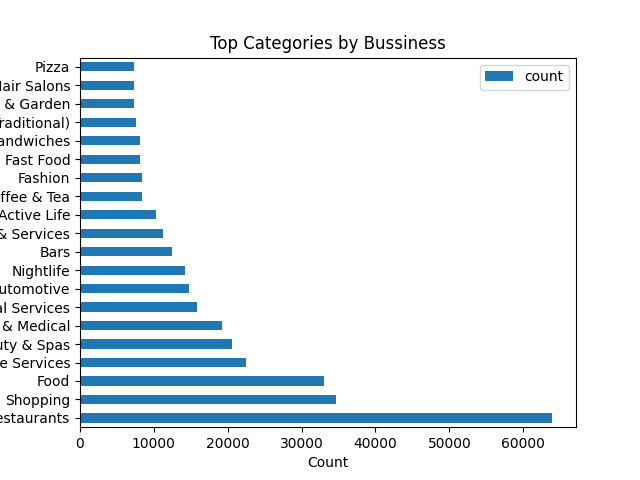

In [126]:
count2.toPandas().plot.barh(y = 'count', x = 'category',title = 'Top Categories by Bussiness')\
.set(xlabel="Count", ylabel = 'Category')

%matplot plt

# Do Yelp Reviews Skew Negative?

In [50]:
df4 = spark.read.json('s3://sta9760-yelpdata-yh/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
df4.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [53]:
df4.createOrReplaceTempView("review")
busstars = spark.sql(
'''
Select business_id, stars From review 
Limit 5
''')
busstars.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+

In [62]:
Avgstars = spark.sql(
'''
Select business_id, avg(stars) as avgstars
From review
Group by business_id
'''
)

Avgstars.createOrReplaceTempView("avgreview")
avgreview = spark.sql(
'''
Select * from avgreview 
Limit 5
''')
avgreview.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|          avgstars|
+--------------------+------------------+
|kvOwcc9VRfD4Nd537...|2.3333333333333335|
|iuya9nmV6ievrTNSO...|3.4683544303797467|
|C7lSQp6iVHIjg2c5T...|3.9836065573770494|
|gwUKjXza3fcdtvBTS...|               4.8|
|SywkoRXyKC5RmLNxc...|               1.0|
+--------------------+------------------+

In [63]:
join = spark.sql(
'''
Select avgreview.*,business.stars,business.name,business.city,business.state 
From business inner join avgreview 
On business.business_id = avgreview.business_id
''')
join.createOrReplaceTempView("joinedtable")
join = spark.sql(
'''
Select * from joinedtable
Limit 5
''')
join.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+-----+--------------------+-----------------+-----+
|         business_id|          avgstars|stars|                name|             city|state|
+--------------------+------------------+-----+--------------------+-----------------+-----+
|-0VImVWDeqewaA3th...|               5.0|  5.0|      Bachelor Vegas|        Las Vegas|   NV|
|-2wh_ZsD2n5xFYgzp...| 4.029411764705882|  4.0|Bonga Korean Rest...|          Calgary|   AB|
|-49WY_TEa9ZEcRk_G...| 3.380952380952381|  3.5|Cracker Barrel Ol...|Sheffield Village|   OH|
|-4QqBR3QGhnjPBXV4...| 4.760869565217392|  5.0|Xpand Realty & Pr...|        Las Vegas|   NV|
|-7bRnaHp7OHz8KW-T...|1.7272727272727273|  1.5|  Buffalo Bill Wings|         Montréal|   QC|
+--------------------+------------------+-----+--------------------+-----------------+-----+

In [78]:
skew = spark.sql(
'''
Select (joinedtable.avgstars - joinedtable.stars) / joinedtable.stars AS skew 
From joinedtable
''')
skew.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                skew|
+--------------------+
|-0.02521008403361...|
|0.009041591320072382|
|-0.01010101010101019|
|                 0.0|
|-0.02950819672131...|
|-0.01893287435456...|
| 0.04032258064516133|
|-0.08800000000000008|
|-0.04444444444444441|
|-0.00751879699248...|
|0.040000000000000036|
|-0.01142857142857...|
|-0.03921568627450...|
|-0.04388422035480863|
|0.019548872180451125|
|-0.00680272108843535|
|-0.06832298136645967|
|                 0.0|
| 0.10000000000000009|
|                 0.0|
+--------------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

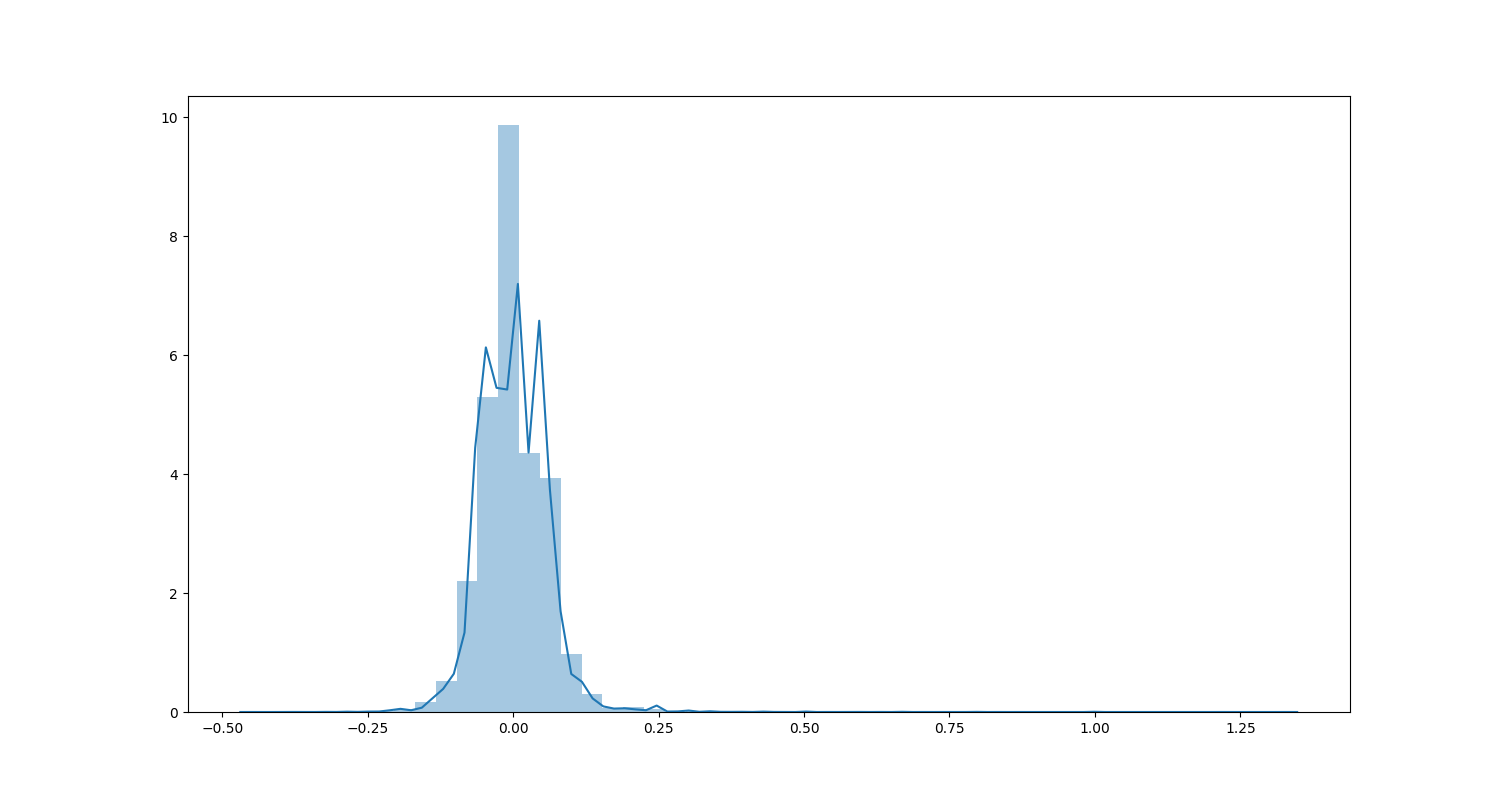

In [80]:
skew = skew.toPandas()
fig = plt.figure(figsize=(15,8))
plot= sns.distplot(skew)
%matplot plt

#### From the graph, the review should be positive skewed, which means there are more people tend to leave negative review. However, if people leave positive review, they also give a high stars. This totally makes sense. Since, people who leave negative review just want to complain or give suggestion. These people may not give a really bad stars eventhough they review negatively. On the other hand, if people leave positive score, they must be very satisified. Those people are more likely to give a five star review.

# Does compliment with photo will receive higher stars?

usually real photo is the most appealing way to get discribe a service. Whether the users who complimenting with photos usually give a better stars than average will be evaluated.  

In [81]:
df_user = spark.read.json('s3://sta9760-yelpdata-yh/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [110]:
df_user.createOrReplaceTempView("user")
join2 = spark.sql(
'''
Select u.compliment_photos, u.user_id, r.stars user_stars, b.business_id, b.stars business_stars
from user u 
inner join review r on r.user_id = u.user_id
inner join business b on r.business_id = b.business_id''')
join2.createOrReplaceTempView("jointable")
join2 = spark.sql('select * from jointable limit 5')
join2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+----------+--------------------+--------------+
|compliment_photos|             user_id|user_stars|         business_id|business_stars|
+-----------------+--------------------+----------+--------------------+--------------+
|                0|--yrdC1dIR6VYsW6k...|       1.0|1F7SjxEmqhFmDfQgp...|           3.0|
|                0|-0VImVWDeqewaA3th...|       5.0|Gyrez6K8f1AyR7dzW...|           4.0|
|                0|-0fu5TVgRGvysK8Wy...|       1.0|sEjy65M87W8dLka1Y...|           3.5|
|                0|-16G-zeLgReYYfgO6...|       5.0|ch_XGu7FpwGKp9m8X...|           4.0|
|                0|-16G-zeLgReYYfgO6...|       2.0|MOd-00nJo6xwg-cZT...|           2.0|
+-----------------+--------------------+----------+--------------------+--------------+

In [112]:
join3 = spark.sql("select * from jointable where compliment_photos > 0")
join3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+--------------------+----------+--------------------+--------------+
|compliment_photos|             user_id|user_stars|         business_id|business_stars|
+-----------------+--------------------+----------+--------------------+--------------+
|                4|-36nnCT71XE0InJXK...|       1.0|GTJzvhsxS_9CqsLRH...|           1.0|
|               33|-3i9bhfvrM3F1wsC9...|       3.0|DYuOxkW4DtlJsTHdx...|           4.0|
|               33|-3i9bhfvrM3F1wsC9...|       4.0|939j88ceB05Te3D7k...|           3.5|
|               33|-3i9bhfvrM3F1wsC9...|       3.0|BLIJ-p5wYuAhw6Pp6...|           3.0|
|               33|-3i9bhfvrM3F1wsC9...|       3.0|yNVcnSaMSrTmjJBMr...|           3.5|
|               33|-3i9bhfvrM3F1wsC9...|       5.0|pSQFynH1VxkfSmehR...|           4.0|
|               33|-3i9bhfvrM3F1wsC9...|       4.0|OARQDsxyoGnnX2FfS...|           4.5|
|               33|-3i9bhfvrM3F1wsC9...|       2.0|bvow46stEejfxnnqE...|           4.0|
|               33|-3i9bhfvrM3F1

In [121]:
join3.createOrReplaceTempView("jointable3")
stardiff = spark.sql(
'''
Select (user_stars-business_stars)/business_stars as diff from jointable3
''')
stardiff.limit(5).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                diff|
+--------------------+
|                 0.0|
|                 0.0|
|-0.14285714285714285|
| 0.14285714285714285|
| -0.1111111111111111|
+--------------------+

In [123]:
join3.createOrReplaceTempView("jointable3")
stardiff = spark.sql(
'''
Select user_stars-business_stars as diff from jointable3
''')
stardiff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+
|diff|
+----+
| 0.0|
|-1.0|
| 0.0|
|-0.5|
|-0.5|
| 0.5|
|-0.5|
|-2.0|
| 0.5|
|-0.5|
| 0.5|
| 0.5|
| 0.5|
| 0.0|
| 1.0|
| 0.5|
| 1.0|
| 1.0|
| 0.5|
| 2.0|
+----+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

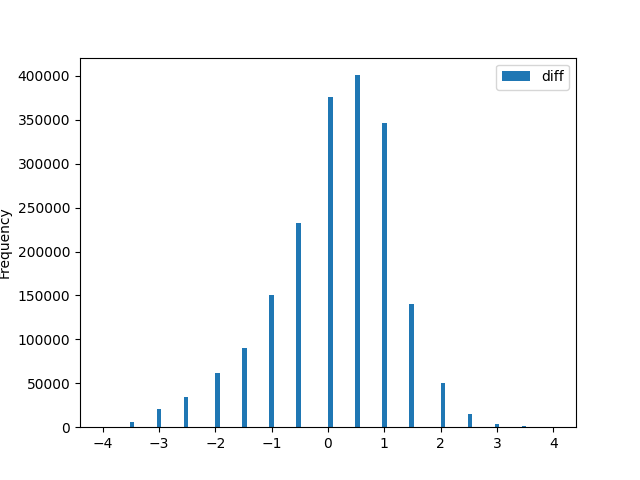

In [130]:
stardiff.toPandas().plot.hist(bins = 100)
%matplot plt

In [131]:
print(stardiff.toPandas().describe())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               diff
count  1.930150e+06
mean   1.109914e-01
std    1.071884e+00
min   -4.000000e+00
25%   -5.000000e-01
50%    0.000000e+00
75%    1.000000e+00
max    4.000000e+00

From this graph, we can tell that people who are complimenting with photo more likeyly to leave a better review. However, business owners also should pay a attention that people who compliment with phote also give a bad review as well. It is not mean the customer who leave a photo loves the service so much. Sometimes can be complain or report too.